In [16]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
from scipy.interpolate import UnivariateSpline # curva sigmoide suavizada
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação do modelo logístico binário
from statstests.process import stepwise # procedimento Stepwise
from scipy import stats # estatística chi2
import plotly.graph_objects as go # gráficos 3D
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from statsmodels.discrete.discrete_model import MNLogit # estimação do modelo
                                                        #logístico multinomial
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, recall_score
import warnings
warnings.filterwarnings('ignore')


In [9]:
# carregar dados
df_atrasados = pd.read_csv(r'Script e Project\atrasado.csv', delimiter=',')
df_atrasados

,estudante,atrasado,dist,sem
0,Gabriela,0,12.5,7
1,Patricia,0,13.3,10
2,Gustavo,0,13.4,8
3,Leticia,0,23.5,7
4,Luiz Ovidio,0,9.5,8
...,...,...,...,...
95,Sheila,1,24.0,10
96,Pedro,1,10.0,10
97,Horacio,1,9.4,10
98,Leandro,1,14.2,10


In [10]:
# característica das variáveis do dataset
df_atrasados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   atrasado   100 non-null    int64  
 2   dist       100 non-null    float64
 3   sem        100 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 3.3+ KB


In [11]:
# estatísticas univariadas
df_atrasados.describe()

,atrasado,dist,sem
count,100.000000,100.000000,100.000000
mean,0.590000,14.073000,10.210000
std,0.494311,4.330112,1.578229
min,0.000000,1.000000,5.000000
25%,0.000000,12.000000,10.000000
50%,1.000000,13.350000,10.000000
75%,1.000000,16.125000,10.000000
max,1.000000,29.000000,18.000000


In [12]:
# tabela de frequência absoluta da variável atrasado
# 1 = atrasado
# 0 = não atrasado

df_atrasados['atrasado'].value_counts()

atrasado
1    59
0    41
Name: count, dtype: int64

In [14]:
# estimação de um modelo logístico binário 
modelo_atrasos = smf.glm(formula='atrasado ~ dist + sem',
                         data=df_atrasados,
                         family=sm.families.Binomial()).fit()

# parâmetros do modelo 
print(modelo_atrasos.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               atrasado   No. Observations:                  100
Model:                            GLM   Df Residuals:                       97
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.466
Date:                Tue, 17 Sep 2024   Deviance:                       100.93
Time:                        15:37:55   Pearson chi2:                     86.7
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2913
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -26.1665      8.442     -3.100      0.0

No modelo logístico binário, a fórmula é expressa como:

$$
\text{logit}(p) = \alpha + \beta_1 \times \text{dist} + \beta_2 \times \text{sem}
$$

Onde:
- \( \alpha = -26.1665 \)
- \( \beta_1 = 0.1904 \) (relacionado à distância)
- \( \beta_2 = 2.3629 \) (relacionado aos semáforos)

In [15]:
# adicionando os valores previstos de probabilidade na base de dados
df_atrasados['phat'] = modelo_atrasos.predict()
df_atrasados


,estudante,atrasado,dist,sem,phat
0,Gabriela,0,12.5,7,0.000712
1,Patricia,0,13.3,10,0.498561
2,Gustavo,0,13.4,8,0.008903
3,Leticia,0,23.5,7,0.005751
4,Luiz Ovidio,0,9.5,8,0.004257
...,...,...,...,...,...
95,Sheila,1,24.0,10,0.884040
96,Pedro,1,10.0,10,0.346606
97,Horacio,1,9.4,10,0.321210
98,Leandro,1,14.2,10,0.541301


In [21]:
# construção da função para a definição da matriz de confusão

def matriz_confusao(predicts, observado, cutoff):
    values = predicts.values
    predicao_binaria = []

    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)

    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    # Visualização dos principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

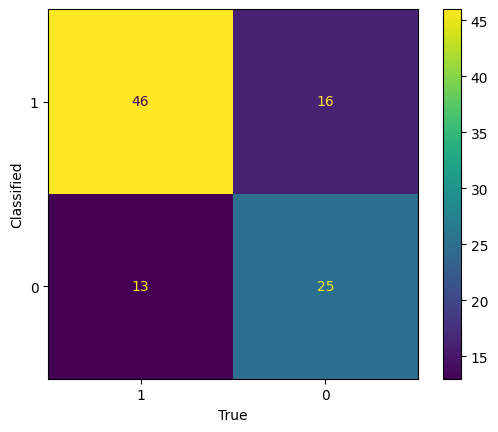

,Sensitividade,Especificidade,Acurácia
0,0.779661,0.609756,0.71


In [22]:
# criação da matriz de confusão
matriz_confusao(observado=df_atrasados['atrasado'],
                predicts=df_atrasados['phat'],
                cutoff=0.5)

